In [2]:
!pip install nltk
!pip install textblob
import nltk
import re
import csv
import pandas
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import naive_bayes
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to C:\Users\pablo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\pablo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Limpieza de texto

In [3]:
#Función para obtener un texto limpio a patir de un texto normal
def limpiar_texto(texto):
    # Eliminar menciones, hashtags, URLs y otros símbolos extraños
    texto = re.sub(r'http\S+', '', texto)  # eliminar URLs
    texto = re.sub(r'#\w+', '', texto)  # eliminar hashtags
    texto = re.sub(r'@\w+', '', texto)  # eliminar menciones
    texto = re.sub(r'[^\w\s]', '', texto)  # eliminar otros símbolos extraños
    
    # Convertir el texto a minúsculas
    texto = texto.lower()
    
    # Tokenización
    tokens = word_tokenize(texto)
    
    # Eliminación de stop words y lematización
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    palabras_limpias = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Unir las palabras limpias en una sola cadena de texto
    texto_limpio = ' '.join(palabras_limpias)
    
    return texto_limpio


### Etiquetado de texto

In [4]:
# Función para etiquetar un texto ya limpio
def etiquetar(texto):
    # Crear un objeto TextBlob con el texto a analizar
    blob = TextBlob(texto)
    # Obtener el valor del análisis de sentimiento
    sentimiento = blob.sentiment.polarity
    # Asignar una etiqueta en función del valor del sentimiento
    if sentimiento >= 0.7:
        etiqueta = "Muy feliz"
    elif sentimiento >= 0.3:
        etiqueta = "Contento"
    elif sentimiento >= -0.3:
        etiqueta = "Neutro"
    elif sentimiento >= -0.7:
        etiqueta = "Molesto"
    else:
        etiqueta = "Hater"
    return etiqueta

In [5]:
# Función para calcular el etiquetado según el número
def calculo_etiqueta_valor(numero):
    if numero == '4':
        etiqueta = "Muy feliz"
    elif numero == '3':
        etiqueta = "Contento"
    elif numero == '2':
        etiqueta = "Neutro"
    elif numero == '1':
        etiqueta = "Molesto"
    else:
        etiqueta = "Hater"
    return etiqueta
    

### Añadir datos al csv

In [6]:
def agregar_columna(input_file):
    with open(input_file, 'r') as file:
        reader = csv.reader(file, delimiter=';')
        rows = list(reader)
        header = rows[0]
        # Añadimos las 3 nuevas columnas
        header.append('Texto limpio')
        header.append('Valor propuesto')
        header.append('Valor calculado')
        for i in range(1, len(rows)):
            # Usamos la columna en la cuál está el texto en bruto
            valor_columna = rows[i][2]  
            # Limpiamos el texto para que pueda ser analizado
            texto_limpio = limpiar_texto(valor_columna)
            # Lo etiquetamos
            texto_etiquetado = etiquetar(texto_limpio)
            # Calculamos el etiquetado que nos propuso el csv
            valor_propuesto = calculo_etiqueta_valor(rows[i][1])
            # Añadimos los nuevos valores
            rows[i].append(texto_limpio) 
            rows[i].append(valor_propuesto)
            rows[i].append(texto_etiquetado)  

    # Guardar los cambios en un nuevo archivo CSV
    output_file = 'DatosFinales.csv'
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerows(rows)

In [15]:
agregar_columna('DatosNuevos.csv')

In [16]:
csvDatos = pandas.read_csv('DatosFinales.csv', delimiter=';',encoding = 'latin-1', header=0,
                       names=['id', 'valoración', 'mensaje', 'texto_limpio',
                              'valor_propuesto', 'valor_calculado'])

In [17]:
# Cantidad total de ejemplos
print(csvDatos.shape)

(5999, 6)


### Selección de atributos y objetivos

In [20]:
atributo = csvDatos['texto_limpio'].values.astype('U')  # selección de las columnas de atributos
objetivo = csvDatos['valor_propuesto']  # selección de la columna objetivo

In [21]:
# El codificador adecuado para tanto el atributo como el objetivo
# es OrdinalEncoder, ya que trabaja con una lista o array
# unidimensional de sus valores
codificador_atributo = CountVectorizer()
codificador_objetivo = preprocessing.LabelEncoder()
atributo_codificado = codificador_atributo.fit_transform(atributo)
objetivo_codificado = codificador_objetivo.fit_transform(objetivo)

# Categorías detectadas por el codificador para cada atributo
print(codificador_atributo.get_feature_names)
print(codificador_objetivo.classes_)

<bound method CountVectorizer.get_feature_names of CountVectorizer()>
['Contento' 'Hater' 'Molesto' 'Muy feliz' 'Neutro']


In [22]:
print(pandas.Series(objetivo).value_counts(normalize=True))

Neutro       0.654609
Contento     0.180530
Molesto      0.079013
Muy feliz    0.068178
Hater        0.017670
Name: valor_propuesto, dtype: float64


### División para entrenamiento y prueba

In [23]:
(atributo_entrenamiento, atributo_prueba,
 objetivo_entrenamiento, objetivo_prueba) = model_selection.train_test_split(
        # Conjuntos de datos a dividir, usando los mismos índices para ambos
        atributo_codificado, objetivo_codificado,
        # Valor de la semilla aleatoria, para que el muestreo sea reproducible,
        # a pesar de ser aleatorio
        random_state=12345,
        # Tamaño del conjunto de prueba
        test_size=.33,
        # Estratificamos respecto a la distribución de valores en la variable objetivo
        stratify=objetivo_codificado)

In [24]:
# Comprobamos que el conjunto de prueba contiene el 33 % de los datos, en la misma proporción
# con respecto a la variable objetivo
print('Cantidad de ejemplos de pruebas requeridos:', 5999 * .33)
print('Filas del array de atributos de prueba:', atributo_prueba.shape[0])
print('Longitud del vector de objetivos de prueba:', len(objetivo_prueba))
print('Proporción de clases en el vector de objetivos de prueba:')
print(pandas.Series(
        codificador_objetivo.inverse_transform(objetivo_prueba)
      ).value_counts(normalize=True))

Cantidad de ejemplos de pruebas requeridos: 1979.67
Filas del array de atributos de prueba: 1980
Longitud del vector de objetivos de prueba: 1980
Proporción de clases en el vector de objetivos de prueba:
Neutro       0.654545
Contento     0.180808
Molesto      0.078788
Muy feliz    0.068182
Hater        0.017677
dtype: float64


In [25]:
# Comprobamos que el conjunto de entrenamiento contiene el resto de los datos, en la misma
# proporción con respecto a la variable objetivo
print('Cantidad de ejemplos de entrenamiento requeridos:', 5999 * .67)
print('Filas del array de atributos de entrenamiento:', atributo_entrenamiento.shape[0])
print('Longitud del vector de objetivos de entrenamiento:', len(objetivo_entrenamiento))
print('Proporción de clases en el vector de objetivos de entrenamiento:')
print(pandas.Series(
        codificador_objetivo.inverse_transform(objetivo_entrenamiento)
      ).value_counts(normalize=True))

Cantidad de ejemplos de entrenamiento requeridos: 4019.3300000000004
Filas del array de atributos de entrenamiento: 4019
Longitud del vector de objetivos de entrenamiento: 4019
Proporción de clases en el vector de objetivos de entrenamiento:
Neutro       0.654640
Contento     0.180393
Molesto      0.079124
Muy feliz    0.068176
Hater        0.017666
dtype: float64


### Prueba Naive Bayes

In [103]:
clasif_NB = naive_bayes.MultinomialNB(alpha=1.0)  # alpha es el parámetro de suavizado
clasif_NB.fit(atributo_entrenamiento.toarray(), objetivo_entrenamiento)

MultinomialNB()

In [104]:
for clase, cantidad_ejemplos_clase, log_probabilidad_clase in zip(
    codificador_objetivo.classes_, clasif_NB.class_count_, clasif_NB.class_log_prior_):
        print(f'Cantidad de ejemplos para la clase {clase}: {cantidad_ejemplos_clase}')
        print(f'Logaritmo de la probabilidad aprendida para la clase {clase}: {log_probabilidad_clase}')

Cantidad de ejemplos para la clase Contento: 725.0
Logaritmo de la probabilidad aprendida para la clase Contento: -1.7126167395945258
Cantidad de ejemplos para la clase Hater: 71.0
Logaritmo de la probabilidad aprendida para la clase Hater: -4.036108517407885
Cantidad de ejemplos para la clase Molesto: 318.0
Logaritmo de la probabilidad aprendida para la clase Molesto: -2.5367370116690235
Cantidad de ejemplos para la clase Muy feliz: 274.0
Logaritmo de la probabilidad aprendida para la clase Muy feliz: -2.68566028806113
Cantidad de ejemplos para la clase Neutro: 2631.0
Logaritmo de la probabilidad aprendida para la clase Neutro: -0.42366911340890745


In [107]:
nuevos_ejemplos = pandas.DataFrame([['Im angry'],
                                    ['Im happy']], columns=['texto_limpio'])
nuevos_ejemplos

,texto_limpio
0,Im angry
1,Im happy


In [108]:
predicciones = clasif_NB.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

array(['Neutro', 'Neutro'], dtype=object)

### Prueba Árboles de Decisión

In [87]:
from sklearn import tree

In [88]:
clasif_CART = tree.DecisionTreeClassifier(
    max_depth=5,  # máxima profundidad del árbol
    random_state=54321  # semilla aleatoria, para que el código sea reproducible
)
clasif_CART.fit(atributo_entrenamiento, objetivo_entrenamiento)

DecisionTreeClassifier(max_depth=5, random_state=54321)

In [89]:
from matplotlib import pyplot

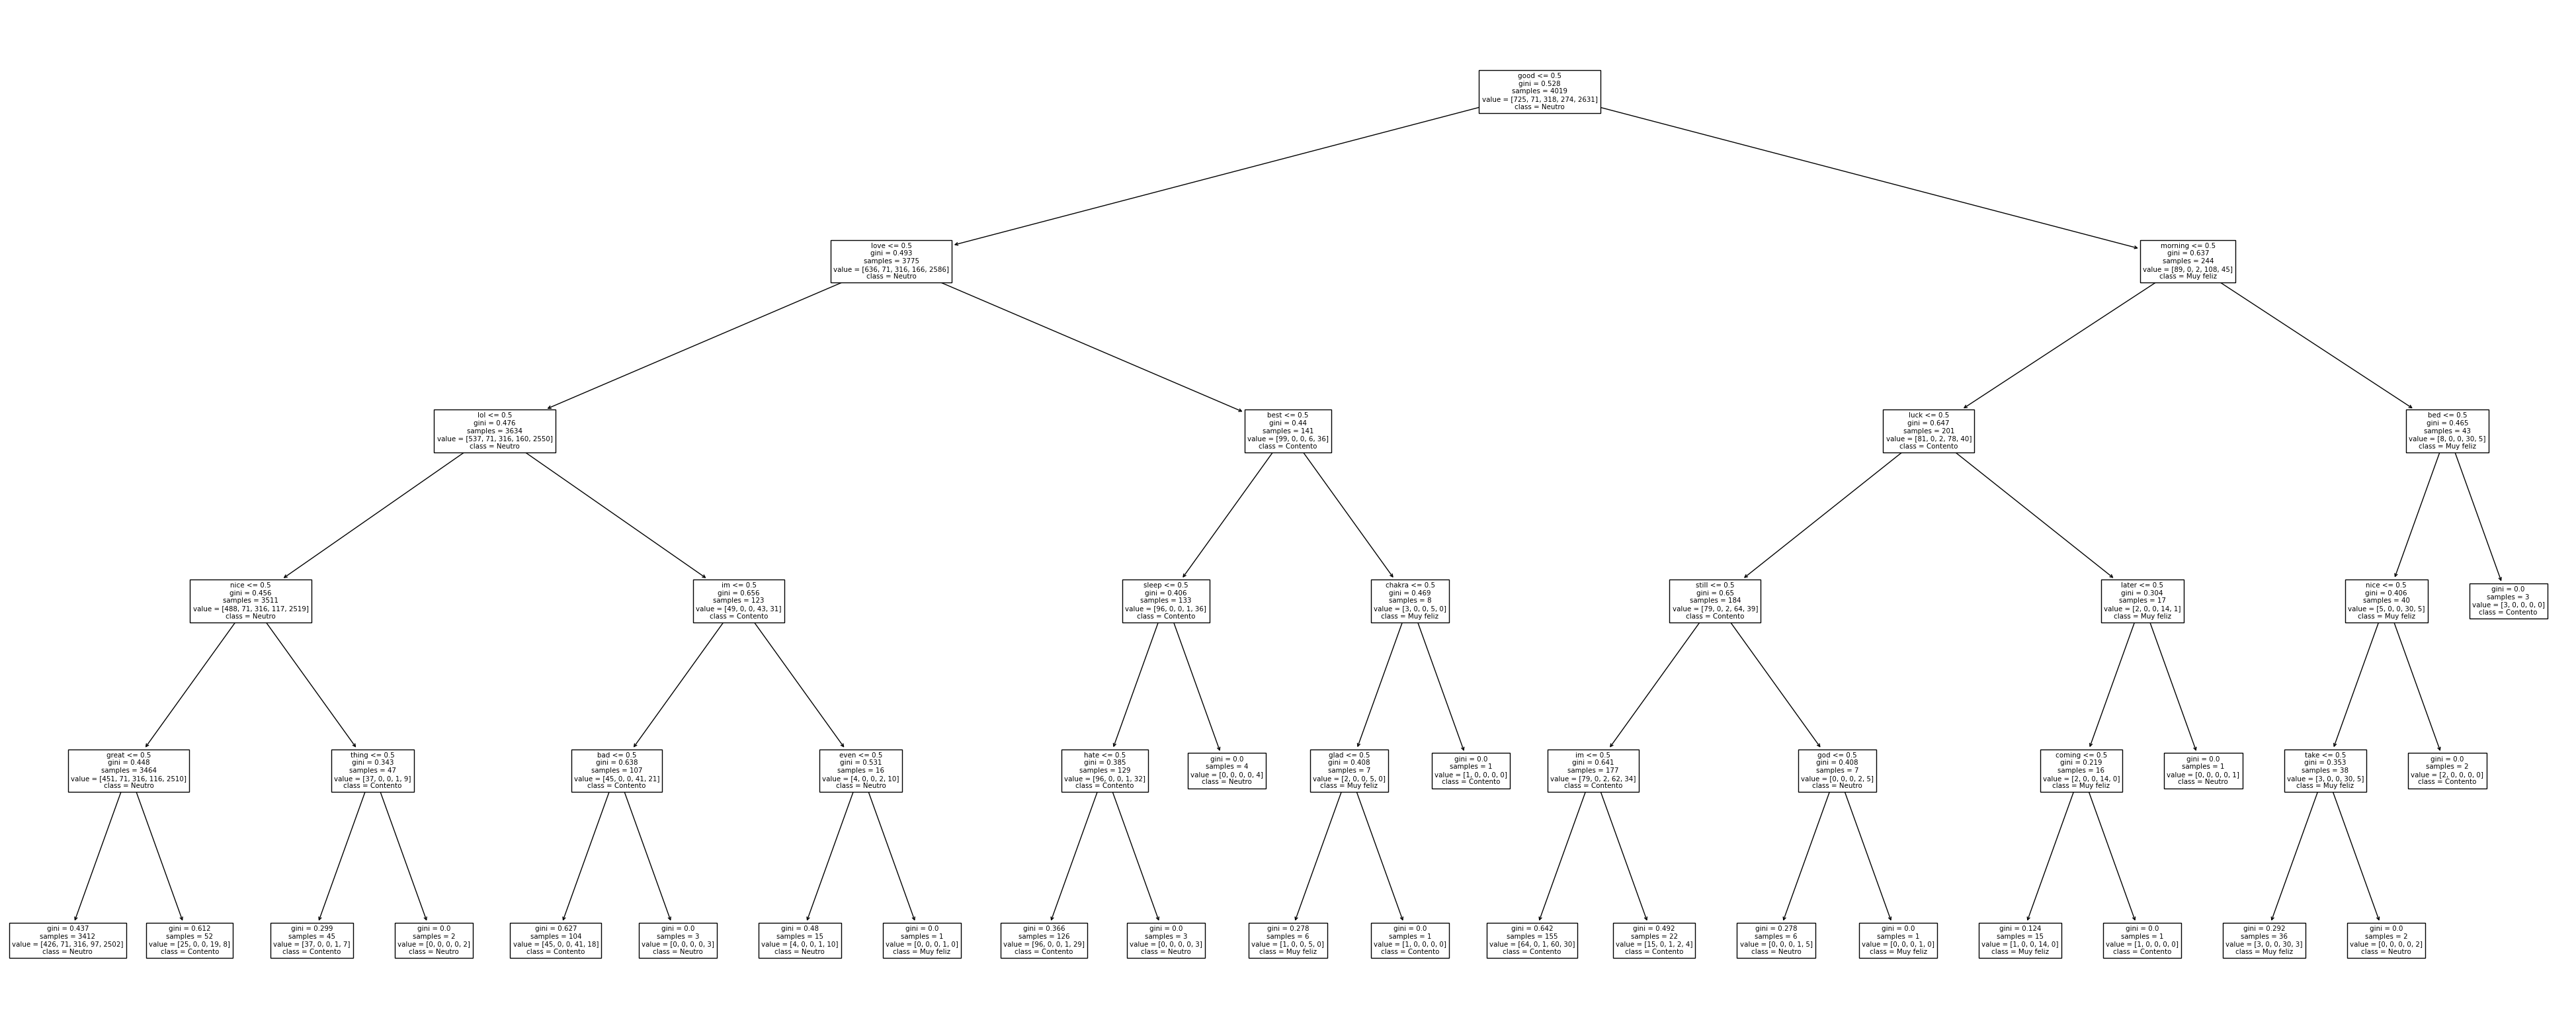

In [97]:
pyplot.figure(figsize=(50, 20))  # Anchura y altura del gráfico
árbol = tree.plot_tree(clasif_CART,
                       feature_names=codificador_atributo.get_feature_names_out(),
                       class_names=codificador_objetivo.classes_)

In [98]:
predicciones = clasif_CART.predict(codificador_atributo.transform(nuevos_ejemplos['texto_limpio']))
codificador_objetivo.inverse_transform(predicciones)

array(['Neutro', 'Neutro'], dtype=object)

### Prueba KNN

In [109]:
from sklearn import neighbors

In [111]:
clasif_kNN = neighbors.KNeighborsClassifier(
    n_neighbors=5,  # Número de vecinos a considerar
    metric='cosine'  # Distancia de Hamming como métrica de cercanía:
                      # fracción de atributos con valores distintos
)
clasif_kNN.fit(atributo_entrenamiento, objetivo_entrenamiento)

KNeighborsClassifier(metric='cosine')

In [113]:
distancias, vecinos = clasif_kNN.kneighbors(codificador_atributo.transform(nuevos_ejemplos))

In [114]:
# Vecinos más cercanos y distancia a ellos del primer ejemplo nuevo
print("Primer ejemplo nuevo:")
print(nuevos_ejemplos.iloc[[0]])
print()
print("5 vecinos más cercanos:")
print(pandas.DataFrame(codificador_atributo.inverse_transform(atributo_entrenamiento[vecinos[0]]),
                       columns=codificador_atributo.get_feature_names_out(),
                       index=vecinos[0]).assign(
    distancia=distancias[0],
    clase=codificador_objetivo.inverse_transform(objetivo_entrenamiento[vecinos[0]])
))

Primer ejemplo nuevo:
  texto_limpio
0     Im angry

5 vecinos más cercanos:


ValueError: 9638 columns passed, passed data had 16 columns